In [1]:
# *EXECUTE*
import gensim.downloader
import torch, nltk
import pandas as pd
import numpy as np
import json, re, random, time, math, importlib
import mrb
importlib.reload(mrb)

<module 'mrb' from 'C:\\Users\\Joseph\\GoogleDrive\\CS\\Academic\\USC\\CSCI467\\FinalProject\\mrb.py'>

In [2]:
# Load embeddings
# *EXECUTE*
embeddings = gensim.downloader.load('glove-wiki-gigaword-50')

In [16]:
# Define models
# *EXECUTE*

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using CUDA.")

class BidirectionalGRURegression(torch.nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        hidden_size = 16
        self.rnn = torch.nn.GRU(input_size=50, hidden_size=hidden_size, num_layers=3, dropout=dropout, bidirectional=True)
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(p=dropout)
        self.fc = torch.nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        r, _ = self.rnn(x)
        return self.fc(self.drop(self.relu(r)))

class BidirectionalGRUClassification(torch.nn.Module):
    def __init__(self, dropout=0.5, hidden_size=12, num_layers=2, bf=False):
        super().__init__()
        self.rnn = torch.nn.GRU(input_size=50, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=True, batch_first=bf)
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(p=dropout)
        self.fc = torch.nn.Linear(hidden_size * 2, 5)
        self.sm = torch.nn.LogSoftmax()

    def forward(self, x):
        r, _ = self.rnn(x)
        return self.sm(self.fc(self.drop(self.relu(r))))

Using CUDA.


In [4]:
# Load data
# *EXECUTE*

df = pd.read_csv("data/dataset_draft.csv")
print(df.columns)

Index(['index', 'url', 'types', 'name', 'desc_snippet', 'recent_reviews',
       'all_reviews', 'release_date', 'developer', 'publisher', 'popular_tags',
       'game_details', 'languages', 'achievements', 'genre',
       'game_description', 'mature_content', 'minimum_requirements',
       'recommended_requirements', 'original_price', 'discount_price', 'appid',
       'total_reviews', 'downloaded', 'full_description'],
      dtype='object')


In [59]:
# Clean data. Modified from similar code in baseline
# *EXECUTE*

nltk.download('punkt')
nltk.download('stopwords')

_cache = {}

def data_transform(value):
    return np.log(np.log(value)) - 1.5

chosen_cutoffs = [0, 19, 40, 108, 446, 4000000]
def class_of(value):
    ind = 0
    while value >= chosen_cutoffs[ind]:
        ind += 1
    return ind - 1

def tokenize(s, other_rm):
    # Preprocess filter
    other_rm = other_rm.lower()
    other_rm = other_rm.split(",")
    other_rm = [i.strip() for i in other_rm]
    
    # Keep alphabetical or space only
    s = re.sub('[^A-Za-z0-9]', ' ', s)
    
    # To lower case
    s = s.lower()
    
    # Remove special words
    for i in other_rm:
        s = s.replace(i, " ")
    
    # Tokenize
    s = nltk.tokenize.word_tokenize(s)
    
    # Filter and stem
    n = []
    for word in s:
        if word not in nltk.corpus.stopwords.words('english') and word not in other_rm:
            # We don't stem words here.
            n.append(word)
    return n

def to_word_vectors(df):
    tks = []
    for i, r in df.iterrows():
        if str(r.appid) in _cache.keys():
            tokens = _cache[str(r.appid)]
            
        else:
            if i % 100 == 0:
                print(i, "/", len(df))
                save_cache("embedding_cache")
            
            if not isinstance(r.game_description, str):
                tokens = []
            else:
                tokens = tokenize(r.game_description, str(r["name"]) + "," + str(r.developer) + "," + str(r.publisher))
            
            _cache[str(r.appid)] = tokens
        
        tks.append(list(tokens))
    
    print("Generating embeddings...")
    res = []
    for game_index in range(len(tks)):
        embed = []
        for word in tks[game_index]:
            if word in embeddings:
                embed.append(embeddings[word])
        res.append(np.array(embed))
    return res

def save_cache(fname):
    with open('data/' + fname + '.json', 'w') as f:
        json.dump(_cache, f)

def load_cache(fname):
    with open('data/' + fname + '.json', 'r') as f:
        _c = json.load(f)
        for k in _c.keys():
            _cache[k] = _c[k]

# We use total_reviews as our objective.
load_cache("embedding_cache")
data = []
wv = to_word_vectors(df)
print("Generating data-objective pairs.")
removed = 0
for i, r in df.iterrows():
    if wv[i].any() == 0:
        removed += 1
        continue
    data.append((torch.from_numpy(wv[i]).to(device), torch.tensor([data_transform(r.total_reviews)], dtype=torch.float32).to(device), torch.tensor([class_of(r.total_reviews)]).to(device), r["name"], r.game_description))
print("Removed", removed, "empty tensors.")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joseph\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Generating embeddings...
Generating data-objective pairs.
Removed 24 empty tensors.


In [60]:
# Generate train/test/dev
# *EXECUTE*

"""
random.shuffle(data)
"""
train_index = 0
dev_index = round(len(data) * 0.7)
test_index = round(len(data) * 0.85)

train, dev, test = data[train_index:dev_index], data[dev_index:test_index], data[test_index:]

print(len(train), len(dev), len(test))


12137 2601 2601


In [ ]:
# Classification task
# *EXECUTE*
importlib.reload(mrb)
epochs = 20
lr = 0.0005
loss = torch.nn.NLLLoss()
spaces = [(16, 4)]
for space in spaces:
    hs = space[0]
    nl = space[1]

    print("\n\nTraining model with HS {0} and NL {1}".format(hs, nl))

    model = BidirectionalGRUClassification(hidden_size=hs, num_layers=nl)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    # Starting
    model.eval()
    random.shuffle(dev)
    avg_loss, correct = 0, 0
    for item in dev:
        print(item[0].shape)
        output = torch.unsqueeze(model(item[0])[-1], 0)

        # Check loss
        l = loss(output, item[2])
        avg_loss += l.item()

        # Check accuracy
        if torch.argmax(output) == item[2].item():
            correct += 1

    losses[(hs, nl)] = [avg_loss / len(test)]
    accuracies[(hs, nl)] = [correct / len(test)]
    print("Starting loss:", avg_loss / len(test))
    print("Starting accuracy:", correct / len(test))

    # Train model
    for epoch in range(epochs):
        print("\nStarting epoch", epoch)
        # Train
        model.train()
        random.shuffle(train)

        batches = mrb.make_random_batches(train, batch_size=batch_size)

        """
        for batch in batches:
            model.zero_grad()
            output = model(batch[0])[:, -1, :]
            l = loss(output, batch[2][:, 0])

            l.backward()
            opt.step()
        """
        #mod_t, b_t, o_t = 0, 0, 0
        for item in train:
            model.zero_grad()
            #a = time.time_ns()
            output = torch.unsqueeze(model(item[0])[-1], 0)
            l = loss(output, item[2])
            l.backward()
            opt.step()

        #print(mod_t / 1000000, b_t / 1000000, o_t / 1000000)
        # Test on dev
        model.eval()
        random.shuffle(dev)
        avg_loss, correct = 0, 0
        for item in dev:
            output = torch.unsqueeze(model(item[0])[-1], 0)

            # Check loss
            l = loss(output, item[2].to(device))
            avg_loss += l.item()

            # Check accuracy
            if torch.argmax(output) == item[2].item():
                correct += 1
        losses[(hs, nl)].append(avg_loss / len(dev))
        accuracies[(hs, nl)].append(correct / len(dev))
        print("Average epoch loss:", losses[(hs, nl)][-1])
        print("Accuracy:", accuracies[(hs, nl)][-1])
        torch.save(model.state_dict(), "models/e{0}_{1}_{2}_class.pth".format(epoch, hs, nl))

    print(losses, accuracies)

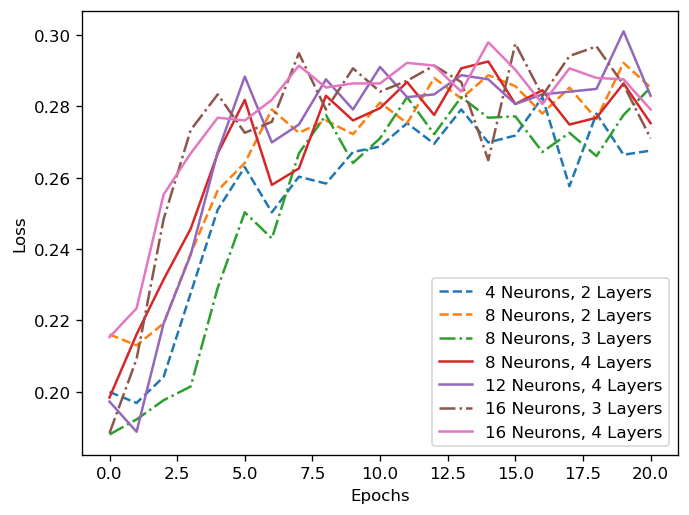

1.5150381239938167
1.5154858154088247


In [77]:
# Generate figure 6
# *EXECUTE*
import matplotlib.pyplot as plt

losses = {(4, 2): [1.6255023533085227, 1.6101164227034301, 1.6078076936427743, 1.6010342395016892, 1.5879422426223755, 1.577422787482259, 1.570160439361842, 1.5662581312890147, 1.5619065026877614, 1.5654878965115282, 1.5624132477655084, 1.5577263063258824, 1.5531217304618026, 1.5470914412397276, 1.545607352522601, 1.544858887052591, 1.5464888277396658, 1.5496655528887286, 1.544023969090017, 1.5431774164428622, 1.5439445555599687], (8, 2): [1.6212563340089174, 1.6075584183102247, 1.6012268776345464, 1.5808637357592261, 1.5714603001591976, 1.5585345776206665, 1.5492808360496149, 1.5631701982465904, 1.537100781527266, 1.536187828274609, 1.5340995775970392, 1.5260493948522873, 1.5232515233335748, 1.5154858154088247, 1.5410690038353605, 1.5230896884904188, 1.5259246997182894, 1.535927105659203, 1.5271761733515818, 1.540420952730342, 1.5312729288595817], (8, 3): [1.6303072518818382, 1.6108203184966718, 1.6106607506523587, 1.6070770491365742, 1.5923010093897225, 1.568581889061596, 1.5728706418207543, 1.5544484456380208, 1.5513928783989466, 1.54674597753098, 1.5444180731450718, 1.5452049811131126, 1.5435602353976718, 1.5456474728879448, 1.535483406443451, 1.5344014181764434, 1.5462321509241554, 1.5382671560154013, 1.5329226562606513, 1.541611592822788, 1.5602643799891796], (8, 4): [1.6157909614771249, 1.6075482527964944, 1.5973191489993679, 1.5792149035621725, 1.5704775588276845, 1.5510565757705632, 1.561201608029754, 1.5550605846752987, 1.5447176148780535, 1.5490071724488708, 1.536438196015239, 1.5390995175666142, 1.5447980832453188, 1.5366295599584532, 1.5409050433968452, 1.5481088262642864, 1.5420311871215684, 1.5701746723597805, 1.547694021488602, 1.5624810263359836, 1.5600238838524876], (12, 4): [1.618815037160138, 1.6103708514888577, 1.6039968933888649, 1.5856651400703965, 1.5560533003090253, 1.5479503233631682, 1.541703593061778, 1.535713843694791, 1.5271159328208066, 1.5476703298110221, 1.5230416824775492, 1.5462863026491178, 1.5412527041360078, 1.529491446342252, 1.542679365032547, 1.5444865002282901, 1.5503134868297153, 1.5703437516049714, 1.5557126809929893, 1.5580970843690307, 1.5860853312463312], (16, 3): [1.6195025938100789, 1.6076718241102372, 1.580024014638507, 1.5570419095012602, 1.5353808014588097, 1.5316687688283028, 1.523556156749223, 1.5232446581778367, 1.5245831548617648, 1.5150381239938167, 1.5433598721442154, 1.5314152237602217, 1.5447196050510184, 1.5424587757185944, 1.5846411896320272, 1.5322348451766772, 1.5718256219625701, 1.5527737508314887, 1.5695796671256521, 1.634932619357329, 1.6711396680960788], (16, 4): [1.610311110172763, 1.607749635464684, 1.5797274210552947, 1.548587167505941, 1.5480250967942215, 1.5602173990627657, 1.5290944494682293, 1.5204124878526237, 1.5338793924706389, 1.5243991202961615, 1.5375024570450788, 1.520784186112656, 1.52816898585145, 1.5360824507688018, 1.5282123162024803, 1.531408921838013, 1.5730142294644438, 1.5823805368162036, 1.54788760387155, 1.556348775852556, 1.592784434720238]}
accuracies = {(4, 2): [0.19992310649750097, 0.19684736639753941, 0.2041522491349481, 0.22760476739715493, 0.2510572856593618, 0.2629757785467128, 0.2502883506343714, 0.26028450595924646, 0.25836216839677045, 0.26720492118415995, 0.2687427912341407, 0.275278738946559, 0.2695117262591311, 0.279123414071511, 0.2698961937716263, 0.2718185313341023, 0.2825836216839677, 0.2575932333717801, 0.2779700115340254, 0.2664359861591695, 0.2675893886966551], (8, 2): [0.21607074202229912, 0.21299500192233756, 0.21914648212226068, 0.23875432525951557, 0.2564398308342945, 0.26412918108419836, 0.279123414071511, 0.27258746635909264, 0.2760476739715494, 0.2722029988465975, 0.28104575163398693, 0.275278738946559, 0.2879661668589004, 0.2821991541714725, 0.2887351018838908, 0.28565936178392926, 0.2779700115340254, 0.28527489427143404, 0.2764321414840446, 0.29219530949634753, 0.28527489427143404], (8, 3): [0.18800461361014995, 0.1922337562475971, 0.19761630142252978, 0.20146097654748174, 0.22914263744713573, 0.2502883506343714, 0.2429834678969627, 0.26682045367166474, 0.2775855440215302, 0.26412918108419836, 0.2710495963091119, 0.2825836216839677, 0.2722029988465975, 0.2825836216839677, 0.2768166089965398, 0.27720107650903497, 0.26720492118415995, 0.27258746635909264, 0.26605151864667437, 0.2775855440215302, 0.28527489427143404], (8, 4): [0.19838523644752018, 0.21607074202229912, 0.2314494425221069, 0.24567474048442905, 0.26682045367166474, 0.2818146866589773, 0.2579777008842753, 0.2625913110342176, 0.2829680891964629, 0.2760476739715494, 0.27950788158400613, 0.28681276432141484, 0.2775855440215302, 0.2906574394463668, 0.29257977700884275, 0.2806612841214917, 0.2845059592464437, 0.2748942714340638, 0.2768166089965398, 0.2864282968089196, 0.275278738946559], (12, 4): [0.1972318339100346, 0.18877354863514034, 0.21914648212226068, 0.23836985774702038, 0.26720492118415995, 0.28835063437139563, 0.2698961937716263, 0.2748942714340638, 0.2875816993464052, 0.279123414071511, 0.29104190695886195, 0.2825836216839677, 0.2833525567089581, 0.2887351018838908, 0.2875816993464052, 0.2806612841214917, 0.2833525567089581, 0.28412149173394846, 0.2848904267589389, 0.30103806228373703, 0.2829680891964629], (16, 3): [0.18838908112264513, 0.20915032679738563, 0.24836601307189543, 0.27335640138408307, 0.2833525567089581, 0.27258746635909264, 0.27566320645905423, 0.2948865820838139, 0.279123414071511, 0.2906574394463668, 0.28412149173394846, 0.28719723183391005, 0.29142637447135716, 0.28681276432141484, 0.2648981161091888, 0.2975778546712803, 0.2829680891964629, 0.29411764705882354, 0.2968089196462899, 0.28604382929642447, 0.2710495963091119], (16, 4): [0.21530180699730872, 0.2233756247597078, 0.2552864282968089, 0.26682045367166474, 0.2768166089965398, 0.2760476739715494, 0.2818146866589773, 0.29142637447135716, 0.28527489427143404, 0.2864282968089196, 0.2864282968089196, 0.29219530949634753, 0.29142637447135716, 0.28412149173394846, 0.2979623221837755, 0.2902729719338716, 0.2806612841214917, 0.2906574394463668, 0.2879661668589004, 0.2875816993464052, 0.279123414071511]}
plt.figure(dpi=120)
ls = list(losses.keys())

ls.sort()
for k in losses:
    a = losses[k]
    ls = "--"
    if k[1] == 3:
        ls = "-."
    if k[1] == 4:
        ls = "-"
    plt.plot(range(len(a)), a, label="{0} Neurons, {1} Layers".format(k[0], k[1]), ls=ls)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

C:\Users\Joseph\AppData\Local\Temp\ipykernel_19128\864188933.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.sm(self.fc(self.drop(self.relu(r))))


Correct bucket: 0.3317954632833526


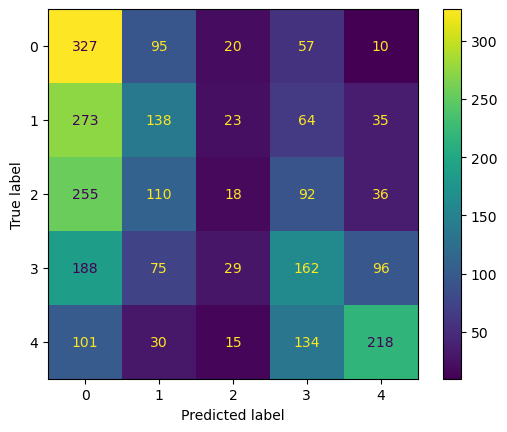

In [72]:
# Show confusion matrix
# *EXECUTE*
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = BidirectionalGRUClassification(hidden_size=16, num_layers=3)
model.load_state_dict(torch.load("models/e9_16_3_class.pth"))
chosen_cutoffs = [2, 19, 40, 108, 446, 4000000]
model.to(device)
model.eval()
correct = 0
o, a = [], []
for item in test:
    output = torch.argmax(model(item[0].to(device))[-1])
    output_bucket, actual_bucket = 0, 0
    o.append(output.item())
    a.append(item[2].item())
    if (o[-1] == a[-1]):
        correct += 1
        
ConfusionMatrixDisplay(confusion_matrix(a, o)).plot()
print("Correct bucket:", correct / len(test))

In [ ]:
# Regression Task
# *EXECUTE*

# Hyperparameters/initialization
lr = 0.0005
model = BidirectionalGRURegression()
loss = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 20

model.to(device)

# Starting
model.eval()
random.shuffle(dev)
avg_loss = 0
for item in test:
    output = model(item[0])
    l = loss(output[-1], item[1])
    avg_loss += l.item()
print("Starting loss:", avg_loss / len(test))

# Train model
losses = []
for epoch in range(epochs):
    print("Starting epoch", epoch)
    # Train
    model.train()
    random.shuffle(train)
    count = 0
    for item in train:
        st = time.time_ns()
        count += 1
        if count % 4000 == 0:
            print(count, "/", len(train))
        model.zero_grad()
        output = model(item[0])
        l = loss(output[-1], item[1])
        l.backward()
        opt.step()
    
    # Test
    model.eval()
    random.shuffle(dev)
    avg_loss = 0
    for item in dev:
        output = model(item[0])
        l = loss(output[-1], item[1])
        avg_loss += l.item()
    losses.append(avg_loss / len(dev))
    print("Average epoch loss:", losses[-1])
    torch.save(model.state_dict(), "models/e" + str(epoch) + "_regression.pth")
    # If 8 epochs have passed, and we're performing even worse, then just stop early.
    #if len(losses) >= 9 and losses[-1] > losses[-9]:
    #    break

Correct bucket: 0.235678585159554


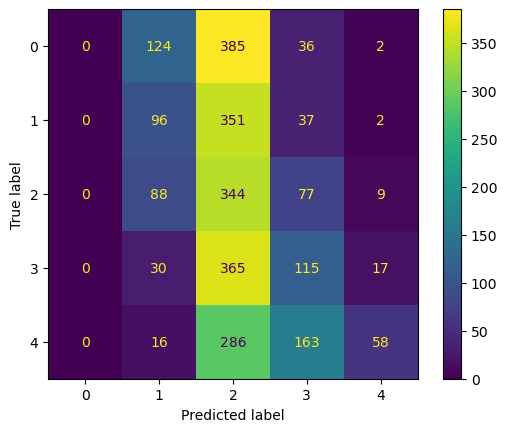

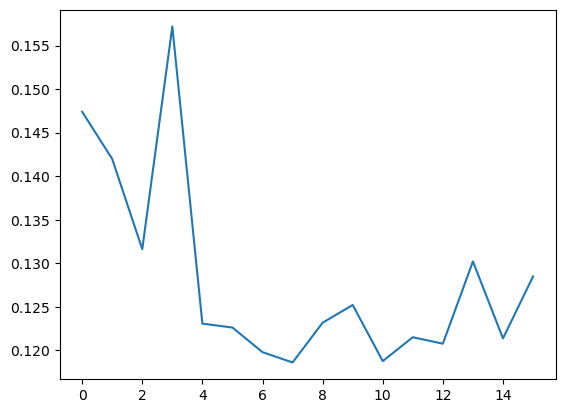

In [74]:
# Compare with original, by bucketing responses
# *EXECUTE*

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

chosen_cutoffs = [2, 19, 40, 108, 446, 4000000]

model.load_state_dict(torch.load("models/e7_regression.pth"))
model.eval()
correct = 0
o, a = [], []
for item in dev:
    output = model(item[0].to(device))[-1]
    output_bucket, actual_bucket = 0, 0
    while output > data_transform(chosen_cutoffs[output_bucket]):
        output_bucket += 1
    while item[1].item() > data_transform(chosen_cutoffs[actual_bucket]):
        actual_bucket += 1
    if output_bucket == actual_bucket:
        correct += 1
    o.append(output_bucket)
    a.append(actual_bucket)
    
ConfusionMatrixDisplay(confusion_matrix(a, o)).plot()
print("Correct bucket:", correct / len(test))

# Display loss graph
plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()